## 1. Importing and pre-processing the data

In [3]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [4]:
# %load functions.py

# fill missing values in the "Fare" column with the mean of the column
# fill missing values in the "Embarked" column with the mode of the column ("S")
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

# process age column into age_categories column containing different categories
def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

# process fare column into fare_categories column with predefined fare categories
def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

# process cabin column into cabin_type column by getting the first char in cabin
def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def pre_process(df):
    """Apply all of the pre-processing functions to a dataframe
    
    Usage
    ------
    
    train = pre_process(train)
    """
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    
    dummy_cols = ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]
    for col in dummy_cols:
        create_dummies(df, col)
    return df
    

In [5]:
train = pre_process(train)
holdout = pre_process(holdout)

## 2. Exploring SibSp (no. of siblings/spouse) and Parch (no. of parents/children) aboard the Titanic 

PassengerId           int64
Survived              int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Embarked             object
Age_categories     category
Fare_categories    category
Cabin_type           object
Title                object
dtype: object


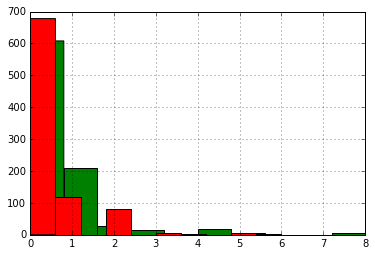

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train.dtypes)
train["SibSp"].hist(color = 'green')
train["Parch"].hist(color = 'red')

Sum_relatives
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Sum_relatives, dtype: int64


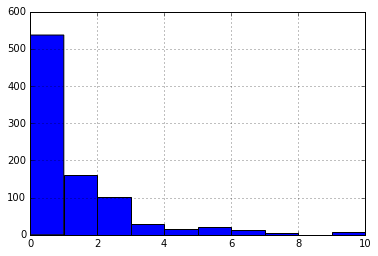

In [7]:
explore = train.copy()
explore["Sum_relatives"] = explore["SibSp"] + explore["Parch"]
print(pd.pivot_table(explore, values = "Survived", index = "Sum_relatives"))
explore["Sum_relatives"].hist()
print(explore["Sum_relatives"].value_counts())

### As can be seen above, we created a new column (Sum_relatives) that sums up the total siblings, spouses, parents, and children on board the Titanic.  The vast majority of people on board the ship had 0 relatives, and their survival rate was only 30%.  

### Survival rate was highest for those with between 1-3 total relatives at >55%.  The highest survival rate was for those with 3 total relatives exactly at 72.4%, but there were only 29 total observations with exactly 3 relatives so the sample size is very small.  

## 3. Feature engineering a new feature (isalone) to determine if the passenger was alone on the ship (0 relatives)

In [8]:
def passenger_isalone(df):
    sum_relatives = df["SibSp"] + df["Parch"]
    df["isalone"] = [1 if x == 0 else 0 for x in sum_relatives]
    return df
train = passenger_isalone(train)
holdout = passenger_isalone(holdout)

In [9]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked Age_categories Fare_categories  \
0      0         A/5 21171   7.2500        S    Young Adult            0-12   
1      0          PC 17599  71.2833        C          Adult          50-100   
2      0  STON/O2. 3101282   7.9250        S    Young Adult            0-12   
3   

## 4. Feature Selection using Recursive Feature Elimination Cross-validation (RFECV) and the Random Forest algorithm

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
def select_features(df):
    # remove non-numeric columns and columns containing nulls
    df = df.select_dtypes(include = ["float64", "int64"])
    df.dropna(axis=1, how='any')
    
    # create X and y for fitting
    all_X = df.drop(["PassengerId", "Survived"], axis = 1)
    all_y = df["Survived"]
    
    # create estimator and selector for feature selection
    estimator = RandomForestClassifier(random_state = 1)
    selector = RFECV(estimator, cv = 10)
    selector.fit(all_X, all_y)
    
    # print and return the best features from all_X
    print(all_X.iloc[:,selector.support_].columns)
    return (all_X.iloc[:, selector.support_].columns)

In [11]:
best_features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


## 5. Model Selection using GridSearchCV to test a range of parameters for RandomForest vs. Kneighbors vs. LogisticRegression

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    lr = {"name": "LogisticRegression",
          "estimator": LogisticRegression(),
          "hyperparameters": 
              {
                  "solver": ["newton-cg", "lbfgs", "liblinear"]
              }
          }
    
    kn = {"name" : "KNeighborsClassifier",
          "estimator": KNeighborsClassifier(),
          "hyperparameters":
              {
                  "n_neighbors": range(1,20,2),
                  "weights": ["distance", "uniform"],
                  "algorithm": ["ball_tree", "kd_tree", "brute"],
                  "p": [1,2] 
              }
         }
    
    rf = {"name": "RandomForestClassifier",
          "estimator": RandomForestClassifier(),
          "hyperparameters":
              {
                  "n_estimators": [4,6,9],
                  "criterion": ["entropy", "gini"],
                  "max_depth": [2, 5, 10],
                  "max_features": ["log2", "sqrt"],
                  "min_samples_leaf": [1,5,8],
                  "min_samples_split": [2,3,5]
              }
         }
    
    model_list = [lr, kn, rf]
    for model in model_list:
        print (model["name"])
        grid = GridSearchCV(model["estimator"], param_grid = model["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        print(model["best_params"])
        print(model["best_score"])
    return model_list

In [13]:
optimized_models = select_model(train, best_features)

LogisticRegression
{'solver': 'liblinear'}
0.701459034792
KNeighborsClassifier
{'algorithm': 'brute', 'weights': 'distance', 'n_neighbors': 15, 'p': 1}
0.698092031425
RandomForestClassifier
{'n_estimators': 9, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_leaf': 8, 'max_depth': 10, 'min_samples_split': 2}
0.737373737374


## 6. Making predictions on the holdout set and submitting to Kaggle

In [14]:
def save_submission_file(model, features, filename = "submission.csv"):
    predictions = model.predict(features)
    submission_dict = {"PassengerId": holdout["PassengerId"],
                       "Survived": predictions}
    submission = pd.DataFrame(submission_dict)
    pd.to_csv(filename, index = False)

In [21]:
best_model = optimized_models[2]["best_estimator"]
print(best_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [ ]:
save_submission_file(best_model, )